In [1]:
from __future__ import annotations

import pathlib

import polars
import seaborn
from matplotlib import pyplot as plt

_ = polars.Config.set_tbl_rows(100)

In [2]:
def load_data(directory: pathlib.Path) -> polars.DataFrame:
    dfs = []
    for run in directory.glob('**/results.csv'):
        try:
            df = polars.read_csv(run)
            if len(df) > 0:
                dfs.append(df)
        except Exception as e:
            print(f'Error loading {run}... skipping: {e}')
    return polars.concat(dfs).sort('num_actors')

In [3]:
baseline_data = load_data(
    pathlib.Path('../data/bench/mailbox-multiplex-v1/baseline'),
).with_columns(polars.lit('baseline').alias('label'))
multiplex_data = load_data(
    pathlib.Path('../data/bench/mailbox-multiplex-v1/multiplex'),
).with_columns(polars.lit('multiplex').alias('label'))
data = polars.concat([baseline_data, multiplex_data])

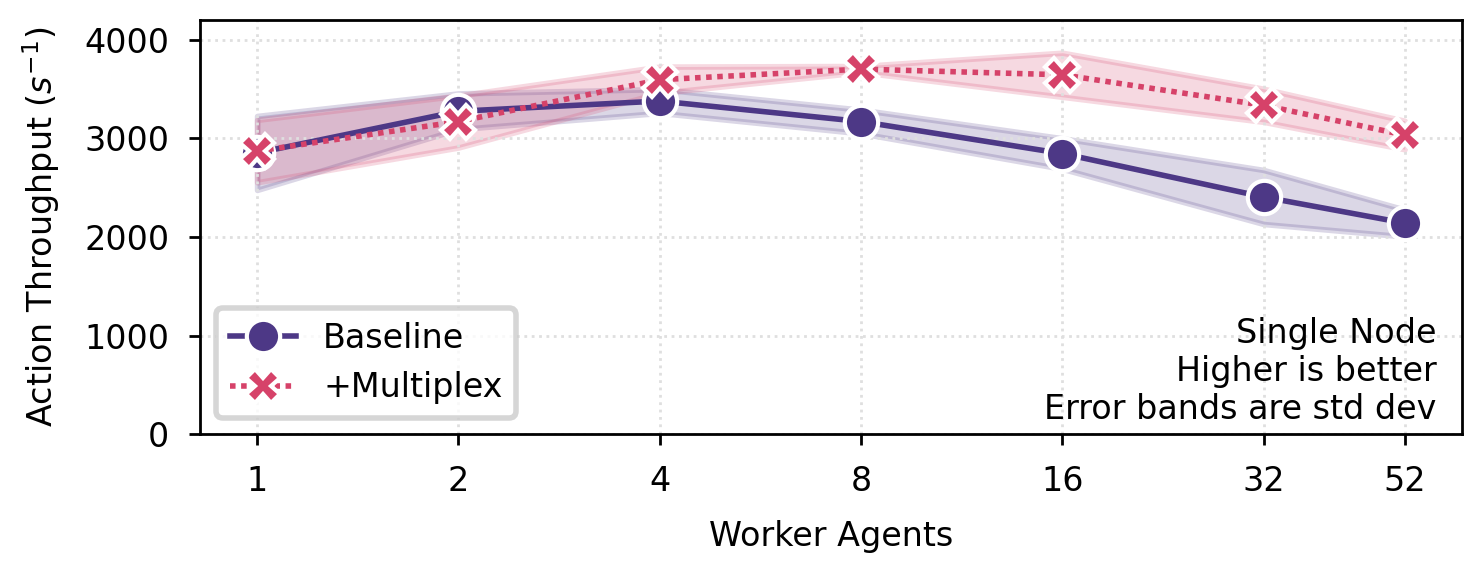

In [4]:
fig, axs = plt.subplots(1, 1)

results = data.with_columns(
    (
        polars.col('num_actors')
        * polars.col('actions_per_actor')
        / polars.col('runtime')
    ).alias('throughput'),
)

xticks = sorted(set(results['num_actors'].to_list()))

dashes = {'multiplex': (1, 1), 'baseline': ()}
markers = {'multiplex': 'X', 'baseline': 'o'}
palette = {'multiplex': '#D64269', 'baseline': '#4D3886'}

handle = seaborn.lineplot(
    results,
    x='num_actors',
    y='throughput',
    hue='label',
    hue_order=['baseline', 'multiplex'],
    style='label',
    errorbar='sd',
    dashes=dashes,
    markers=markers,
    palette=palette,
    ax=axs,
)
handles, _ = axs.get_legend_handles_labels()
axs.legend(
    loc='lower left',
    handles=handles,
    title=None,
    labels=['Baseline', '+Multiplex'],
)
_ = handle.set(
    xscale='log',
    # yscale='log',
    xlabel='Worker Agents',
    ylabel='Action Throughput ($s^{-1}$)',
)
handle.set_xticks(xticks, minor=False)
handle.set_xticklabels([str(x) for x in xticks])
axs.tick_params(axis='x', which='minor', bottom=False)
axs.set(ylim=[0, 4200])

axs.annotate(
    'Single Node\nHigher is better\nError bands are std dev',
    xy=(0.98, 0.02),
    xycoords=('axes fraction'),
    ha='right',
    va='bottom',
)

fig.tight_layout()
plt.draw()
fig.set_size_inches(3.5, 1.15)
fig.savefig('figures/mailbox-multiplex.pdf')

In [5]:
results.group_by(
    'framework',
    'actions_per_actor',
    'num_nodes',
    'num_workers_per_node',
    'num_actors',
    'label',
).mean()

framework,actions_per_actor,num_nodes,num_workers_per_node,num_actors,label,runtime,throughput
str,i64,i64,i64,i64,str,f64,f64
"""academy""",100,1,4,4,"""baseline""",0.11854,3377.847853
"""academy""",100,1,32,32,"""multiplex""",0.961659,3334.385656
"""academy""",100,1,8,8,"""baseline""",0.252661,3170.028148
"""academy""",100,1,32,32,"""baseline""",1.34385,2405.056134
"""academy""",100,1,52,52,"""multiplex""",1.717288,3033.266153
"""academy""",100,1,16,16,"""multiplex""",0.440523,3643.963733
"""academy""",100,1,1,1,"""multiplex""",0.035206,2870.486036
"""academy""",100,1,2,2,"""multiplex""",0.063457,3169.773988
"""academy""",100,1,16,16,"""baseline""",0.563679,2845.519349
